# Лабораторная работа #2. Стохастический градиентный спуск
**Выполнили**: Бессонницын Евгений (M32341), Чеботарева Олеся (М34351), Фадеев Олег (M32351)


In [37]:
import copy

import numpy
!pip install memory_profiler

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

## Пункт #1: Стохастический градиентный спуск

In [39]:
RANDOM_CONST = 42
TEST_SIZE = 0.2
np.random.seed(RANDOM_CONST)

In [40]:
def predict(w, x):
    return np.dot(w, x)

def calc_diff(w, x, y):
    return 2 * (predict(w, x) - y) * x

def calc_error(w, x, y):
    return (predict(w, x) - y) ** 2

def validate(w, X, Y):
    errors = [calc_error(w, X[i], Y[i]) for i in range(len(X) - 1)]
    return sum(errors) / len(X)

In [41]:
def SGD(minibatch_size, num_iters, lr, X, Y):
    n = len(X)
    w = np.zeros(len(X[0]))
    for i in range(num_iters):
        perm = np.random.permutation(n)
        for k in range(0, n, minibatch_size):
            grad = np.zeros(len(X[0]))
            for j in range(min(minibatch_size, n - k - 1)):
                idx = perm[k + j]
                grad += calc_diff(w, X[idx], Y[idx])
            w -= lr * grad
    return w

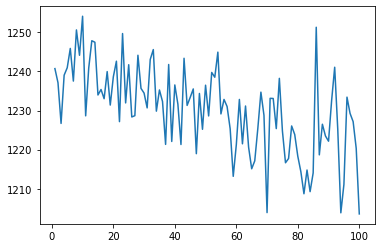

In [42]:
X, Y = make_regression(n_samples=100, n_features=10)

new_X = [np.concatenate((np.array([1]), x), axis=None) for x in X]
X = new_X

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_CONST)

x = [i for i in range(1, 100 + 1)]
y = [validate(SGD(i, 100, 0.0001, X_train, Y_train), X_test, Y_test) for i in range(1, 100 + 1)]
plt.plot(x, y)
plt.show()

## Пункт #3: Модификации

In [43]:
eps = 1e-8

def step_simple(lr, grad, w_i, prev_g):
    res = lr * grad(w_i)
    prev = lr * grad(w_i)
    return res, prev

def step_Nesterov(lr, grad, w_i, prev_g):
    res = lr * grad(w_i - 0.99 * prev_g) + 0.99 * prev_g
    prev = lr * grad(w_i - 0.99 * prev_g) + 0.99 * prev_g
    return res, prev

def step_momentum(lr, grad, w_i, prev_g):
    res = lr * grad(w_i) + 0.8 * prev_g
    prev = lr * grad(w_i) + 0.8 * prev_g
    return res, prev

def step_adagrad(lr, grad, w_i, prev_g):
    curr_grad = grad(w_i)
    tmp = [prev_g[j] + (curr_grad[j]) ** 2 for j in range(len(prev_g))]
    rate = [0.9 / (tmp[i] + eps) ** 0.5 for i in range(len(tmp))]
    return curr_grad * rate, tmp

In [44]:
def SGD_with_mods(minibatch_size, num_iters, lr, mod, X, Y):
    n = len(X)
    ws = []
    trace = []
    w = np.zeros(len(X[0]))
    for i in range(num_iters):
        perm = np.random.permutation(n)
        k = 0
        if i % 10 == 0:
            trace.append([X[perm[0]], Y[perm[0]]])

        def calc_grad(w):
            grad = np.zeros(len(X[0]))
            for j in range(min(minibatch_size, n - k - 1)):
                idx = perm[k + j]
                grad = grad + calc_diff(w, X[idx], Y[idx])
            return grad

        prev_g = np.zeros(len(X[0]))
        while k < n:
            tmp, prev = mod(lr, calc_grad, w, prev_g)
            w = w - tmp
            prev_g = copy.deepcopy(prev)
            k += minibatch_size
        if i % 10 == 0:
            ws.append(w)
    return w, ws, trace

In [45]:
num_features = 100
num_samples = 100
tmp, Y = make_regression(n_samples=num_samples, n_features=num_features)

Y = np.array(Y, dtype=numpy.float64)

X = []
for x in tmp:
    arr = [1]
    for elem in x:
        arr.append(elem)
    X.append(np.array(arr, dtype=numpy.float64))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_CONST)

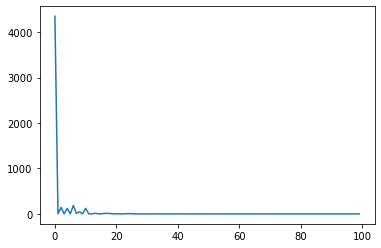

In [46]:
w, ws, trace = SGD_with_mods(50, 1000, 0.001, step_simple, X_train, Y_train)  # refactoring grafics
y = [(trace[i][1] - predict(ws[i], trace[i][0])) ** 2 for i in range(len(trace))]
x = [i for i in range(len(trace))]
plt.plot(x, y)
plt.show()

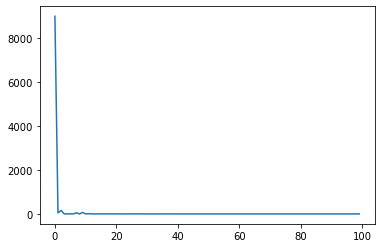

In [47]:
w, ws, trace = SGD_with_mods(50, 1000, 0.001, step_momentum, X_train, Y_train)
y = [(trace[i][1] - predict(ws[i], trace[i][0])) ** 2 for i in range(len(trace))]
x = [i for i in range(len(trace))]
plt.plot(x, y)
plt.show()

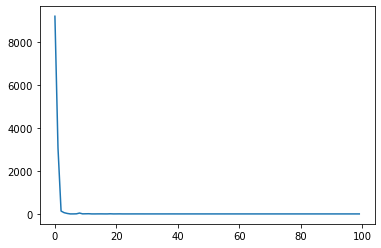

In [48]:
w, ws, trace = SGD_with_mods(50, 1000, 0.001, step_Nesterov, X_train, Y_train)
y = [(trace[i][1] - predict(ws[i], trace[i][0])) ** 2 for i in range(len(trace))]
x = [i for i in range(len(trace))]
plt.plot(x, y)
plt.show()

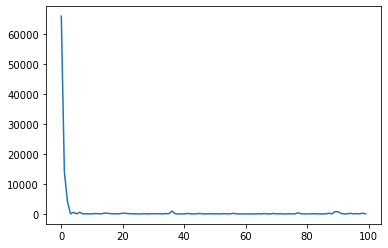

In [49]:
w, ws, trace = SGD_with_mods(50, 1000, 0.001, step_adagrad, X_train, Y_train)
y = [(trace[i][1] - predict(ws[i], trace[i][0])) ** 2 for i in range(len(ws))]
x = [i for i in range(len(ws))]

plt.plot(x, y)
plt.show()

## Пункт #4: Исследование сходимости разных алгоритмов

In [55]:
import time


class Statistics():
    def __init__(self):
        self.error: float = 0.0
        self.grad_call_count: int = 0
        self.time_sec: float = 0
        self.memory_mb: float = memory_usage()[0]

    def print(self, minibatch_size, algo):
        print("-------------------------===-------------------------")
        print()
        print(f"Algo: ", algo)
        print("Minibatch size ", minibatch_size)
        print("Error ", self.error)
        print(f"Time: {self.time_sec} sec")
        print("Gradient calls: ", self.grad_call_count)


def SGD_with_mods_and_stat(minibatch_size, num_iters, lr, mod, X, Y):
    statistics = Statistics()
    start = time.time()
    n = len(X)
    ws = []
    trace = []
    w = np.zeros(len(X[0]), dtype=numpy.float64)
    for i in range(num_iters):
        perm = np.random.permutation(n)
        k = 0
        if i % 10 == 0:
            trace.append([X[perm[0]], Y[perm[0]]])

        def calc_grad(w):
            grad = np.zeros(len(X[0]))
            for j in range(min(minibatch_size, n - k - 1)):
                idx = perm[k + j]
                statistics.grad_call_count += 1
                grad = grad + calc_diff(w, X[idx], Y[idx])
            return grad

        prev_g = np.zeros(len(X[0]))
        while k < n:
            tmp, prev = mod(lr, calc_grad, w, prev_g)
            w = w - tmp
            prev_g = copy.deepcopy(prev)
            k += minibatch_size
        if i % 10 == 0:
            ws.append(w)

    statistics.grad_call_count += minibatch_size * num_iters
    statistics.time_sec = time.time() - start
    return w, ws, trace, statistics


X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_CONST)

x_norm = []
y_norm = []
algos = [step_simple, step_momentum, step_Nesterov, step_adagrad]
algos_name = ["No modification", "Momentum", "Nesterov", "Adagrad"]

for i in range(20, 81, 10):
    for ai in range(len(algos)):
        w, ws, trace, statistics = SGD_with_mods_and_stat(i, 1000, 0.001, algos[ai], X_train_norm, Y_train_norm)
        statistics.error = validate(w, X_test_norm, Y_test_norm)
        statistics.print(i, algos_name[ai])

-------------------------===-------------------------

Algo:  No modification
Minibatch size  20
Error  1.960486982416574e-27
Time: 0.6103389263153076 sec
Gradient calls:  178000
-------------------------===-------------------------

Algo:  Momentum
Minibatch size  20
Error  5.235374005112398e-28
Time: 0.5551490783691406 sec
Gradient calls:  178000
-------------------------===-------------------------

Algo:  Nesterov
Minibatch size  20
Error  5.228570079804866e-28
Time: 0.5761611461639404 sec
Gradient calls:  178000
-------------------------===-------------------------

Algo:  Adagrad
Minibatch size  20
Error  0.003141188191566517
Time: 0.3207540512084961 sec
Gradient calls:  99000
-------------------------===-------------------------

Algo:  No modification
Minibatch size  30
Error  1.3343582211813415e-27
Time: 0.5490221977233887 sec
Gradient calls:  188000
-------------------------===-------------------------

Algo:  Momentum
Minibatch size  30
Error  5.237247549762297e-28
Time: 0.5

## Пункт #5: Траектории спуска различных алгоритмов

In [51]:
def SGD_with_mods_and_space(minibatch_size, num_iters, lr, mod, X, Y, space):
    n = len(X)
    ws = []
    trace = []
    w = np.zeros(len(X[0]), dtype=numpy.float64)
    for i in range(num_iters):
        perm = np.random.permutation(n)
        k = 0
        if i % 10 == 0:
            trace.append([X[perm[0]], Y[perm[0]]])

        def calc_grad(w):
            grad = np.zeros(len(X[0]))
            for j in range(min(minibatch_size, n - k - 1)):
                idx = perm[k + j]
                grad = grad + calc_diff(w, X[idx], Y[idx])
            return grad

        prev_g = np.zeros(len(X[0]))
        while k < n:
            tmp, prev = mod(lr, calc_grad, w, prev_g)
            w = w - tmp
            prev_g = copy.deepcopy(prev)
            k += minibatch_size
        if i % 10 == 0:
            ws.append(w)
    return w, ws, trace

num_features = 1
num_samples = 100
tmp, Y = make_regression(n_samples=num_samples, n_features=num_features)

Y = np.array(Y, dtype=numpy.float64)

X = []
for x in tmp:
    arr = [1]
    for elem in x:
        arr.append(elem)
    X.append(np.array(arr, dtype=numpy.float64))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_CONST)

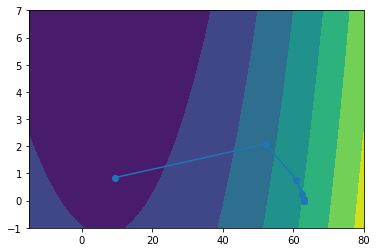

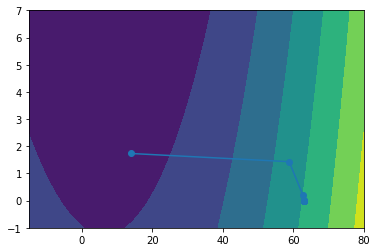

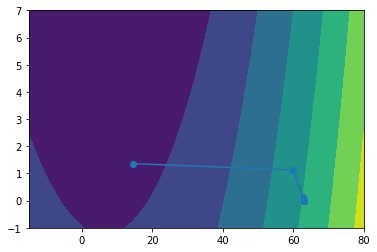

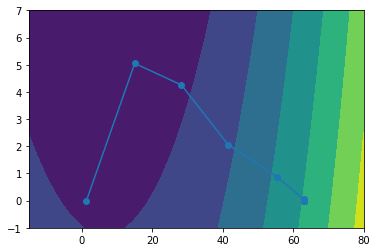

In [63]:
algos = [step_simple, step_momentum, step_Nesterov, step_adagrad]
space = np.linspace(-15, 80, 100)
space1 = np.linspace(-1, 7, 100)

def calc_big_error(w, Xs, Ys):
    arr = [calc_error(w, Xs[i], Ys[i]) for i in range(len(Xs))]
    return sum(arr)

for algo in algos:
    w, ws, trace = SGD_with_mods_and_space(50, 1000, 0.001, algo, X_train, Y_train, space)
    w0 = [ws[i][0] for i in range(len(ws))]
    w1 = [ws[i][1] for i in range(len(ws))]
    plt.plot(w1, w0, 'o-')
    x1, y1 = np.meshgrid(space, space1)
    z = []
    for i in range(len(x1)):
        z.append([])
        for j in range(len(x1)):
            z[i].append(calc_big_error([x1[i][j], y1[i][j]], X_train, Y_train))
    plt.contourf(x1, y1, z)
    plt.show()